<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
#Start Here

#Importing and reading the dataframe
import pandas as pd
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [2]:
df.shape

(28332, 24)

In [3]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [4]:
df['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

In [5]:
df = df[df['primaryCategories'] == 'Electronics']

In [6]:
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
8343,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,Great case to keep everything in its place! My...,Excellent product,qs341_5,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...
8344,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,NaN,5,http://www.amazon.co.uk/gp/product-reviews/B00...,After discarding and getting rid of broken cd ...,It was a much needed storage,Diablita,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...
8345,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,NaN,5,https://www.ebay.com/itm/Amazonbasics-Nylon-Cd...,"A few dollars more, but I am boycotting amazon",it was worth it,coldbloodblazing,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...
8346,AVpe7nGV1cnluZ0-aG2o,2014-10-28T11:14:38Z,2019-04-25T09:05:28Z,AmazonBasics Nylon CD/DVD Binder (400 Capacity),"B00DIHVMEA,B00EZ1ZTV0",Amazonbasics,"Audio & Video Accessories,TV, Video & Home Aud...",Electronics,http://ecx.images-amazon.com/images/I/41jQha7Z...,amazonbasicsnyloncddvdbinder400capacity/b00ez1...,...,NaN,NaN,NaN,NaN,2,http://www.amazon.co.uk/gp/product-reviews/B00...,My initial impression of this was very good. T...,"Not well designed, very tight when full. Becom...",Snrub,https://www.ebay.com/itm/AmazonBasics-Nylon-CD...
8347,AVpfl8cLLJeJML43AE3S,2016-04-08T18:16:28Z,2019-04-25T08:51:22Z,Amazon Echo ‚Äì White,"B01E6AO69U,B00L9EPT8O",Amazon,"Stereos,Remote Controls,Audio Docks & Mini Spe...",Electronics,https://i.ebayimg.com/images/g/NWEAAOSwDehbdx6...,"amazonechowhite/b00l9ept8o,amazonechowhite/b01...",...,True,NaN,NaN,NaN,5,https://www.newegg.com/Product/Product.aspx?It...,Pros: Standard Echo. Cons: Older generation Ec...,Arrived as described.,Anonymous,https://www.newegg.com/Product/Product.aspx?It...


In [7]:
df = df[['primaryCategories','reviews.text']].copy()

In [8]:
df.head()

,primaryCategories,reviews.text
8343,Electronics,Great case to keep everything in its place! My...
8344,Electronics,After discarding and getting rid of broken cd ...
8345,Electronics,"A few dollars more, but I am boycotting amazon"
8346,Electronics,My initial impression of this was very good. T...
8347,Electronics,Pros: Standard Echo. Cons: Older generation Ec...


In [9]:
df['reviews.text'][8343]

'Great case to keep everything in its place! My husband love it!!!! Holds a lot of cds!'

In [10]:
df.shape

(13995, 2)

In [11]:
# The text looks pretty clean, not gonna try cleaning it, may be will return later.

## Tokenization

In [12]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [13]:
# Creating tokens

tokens = []

for doc in nlp.pipe(df['reviews.text']):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.is_stop != True) and (token.pos_ != 'PRON')) and (token.is_punct !=True):
            doc_tokens.append(token.lemma_.strip())
            
    tokens.append(doc_tokens)

In [14]:
len(tokens) == df.shape[0]

True

## Fitting a Gensim LDA topic model

In [15]:
import gensim

from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [16]:
id2word = corpora.Dictionary(tokens)

In [17]:
len(id2word.keys())

6832

In [18]:
# Filtering the extremes
id2word.filter_extremes(no_below=5, no_above=.95)

In [19]:
len(id2word.keys())

2247

In [20]:
corpus = [id2word.doc2bow(doc) for doc in tokens]

In [21]:
corpus[5]

[(16, 1),
 (23, 1),
 (51, 1),
 (82, 1),
 (112, 1),
 (114, 1),
 (117, 1),
 (118, 1),
 (119, 1),
 (120, 1),
 (121, 1),
 (122, 1),
 (123, 1)]

In [22]:
# Creating model
lda = LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  num_topics=15, 
                  passes=50)

In [23]:
lda.print_topics()

[(0,
  '0.032*"daughter" + 0.031*"tablet" + 0.021*"Amazon" + 0.020*"app" + 0.018*"new" + 0.016*"use" + 0.015*"work" + 0.014*"device" + 0.012*"like" + 0.012*"want"'),
 (1,
  '0.065*"purchase" + 0.048*"Fire" + 0.034*"buy" + 0.031*"happy" + 0.027*"Amazon" + 0.026*"8" + 0.025*"love" + 0.025*"product" + 0.022*"great" + 0.022*"tablet"'),
 (2,
  '0.033*"book" + 0.024*"tablet" + 0.022*"reader" + 0.022*"need" + 0.020*"read" + 0.019*"e" + 0.018*"app" + 0.015*"Google" + 0.015*"buy" + 0.014*"Amazon"'),
 (3,
  '0.070*"old" + 0.067*"year" + 0.051*"tablet" + 0.032*"buy" + 0.027*"love" + 0.021*"2" + 0.016*"great" + 0.016*"charge" + 0.015*"3" + 0.015*"kid"'),
 (4,
  '0.028*"music" + 0.027*"speaker" + 0.026*"sound" + 0.026*"Alexa" + 0.024*"great" + 0.019*"tap" + 0.017*"Amazon" + 0.016*"Echo" + 0.014*"listen" + 0.013*"portable"'),
 (5,
  '0.076*"love" + 0.054*"buy" + 0.040*"Kindle" + 0.035*"get" + 0.034*"Christmas" + 0.029*"wife" + 0.028*"old" + 0.025*"gift" + 0.019*"new" + 0.018*"year"'),
 (6,
  '0.084*

In [24]:
import re
words = [re.findall('"([^"]*)"',t[1]) for t in lda.print_topics()]

In [25]:
topics = [' '.join(t[0:5]) for t in words]

In [26]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
daughter tablet Amazon app new

------ Topic 1 ------
purchase Fire buy happy Amazon

------ Topic 2 ------
book tablet reader need read

------ Topic 3 ------
old year tablet buy love

------ Topic 4 ------
music speaker sound Alexa great

------ Topic 5 ------
love buy Kindle get Christmas

------ Topic 6 ------
tablet great good price use

------ Topic 7 ------
great tablet screen easy size

------ Topic 8 ------
love kid great tablet use

------ Topic 9 ------
easy use tablet app love

------ Topic 10 ------
gift great laptop member case

------ Topic 11 ------
game play love watch book

------ Topic 12 ------
book read Kindle internet like

------ Topic 13 ------
kindle light fire read love

------ Topic 14 ------
good price tablet product great



## Visualization

In [27]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [28]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.163645 -0.086856       1        1  9.190386
6     -0.154817  0.032046       2        1  9.032588
8      0.103939 -0.037666       3        1  8.045197
7     -0.155879 -0.035902       4        1  7.904174
11     0.174430  0.109331       5        1  7.663262
14    -0.192938 -0.154276       6        1  6.784016
9      0.037705  0.143444       7        1  6.747732
4     -0.080634  0.049878       8        1  6.533489
5      0.203857 -0.111750       9        1  6.489156
1      0.020770 -0.193065      10        1  6.424367
2     -0.036645  0.119136      11        1  5.972446
13     0.007250  0.116215      12        1  5.625712
0      0.027665  0.019733      13        1  5.169107
12    -0.065117  0.115971      14        1  4.687584
10    -0.053230 -0.086240      15        1  3.730773, topic_info=          Term         Freq        Total Category  logprob  loglift
68        easy  2553.000000  2553.000000  Default  30.0000  30.0000
924        kid  1922.000000  1922.000000  Default  29.0000  29.0000
806       game  1483.000000  1483.000000  Default  28.0000  28.0000
108       year  1498.000000  1498.000000  Default  27.0000  27.0000
5         love  4557.000000  4557.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
168  recommend    50.390079   810.482117  Topic15  -4.9207   0.5107
20        like    52.002705  1697.006104  Topic15  -4.8892  -0.1968
619       read    50.531158  1634.798462  Topic15  -4.9179  -0.1881
5         love    53.557049  4557.732910  Topic15  -4.8597  -1.1553
183   purchase    49.249859  1574.215576  Topic15  -4.9436  -0.1761

[1101 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
951       1  0.034509       $
951       2  0.128176       $
951       5  0.004930       $
951       6  0.594044       $
951       8  0.039439       $
...     ...       ...     ...
1686      5  0.179301     yrs
1686      9  0.776970     yrs
1686     15  0.059767     yrs
432      15  0.966543  zipper
2094      7  0.907926       ©

[3300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 9, 8, 12, 15, 10, 5, 6, 2, 3, 14, 1, 13, 11])

In [29]:
# store our data in aa dataframe
distro = [lda[d] for d in corpus]

In [30]:
def update(doc):
        d_dist = {k:0 for k in range(0, len(lda.get_topics()))}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [31]:
doc_topics = pd.DataFrame.from_records(new_distro)
doc_topics.columns = topics

In [32]:
doc_topics.head()

,daughter tablet Amazon app new,purchase Fire buy happy Amazon,book tablet reader need read,old year tablet buy love,music speaker sound Alexa great,love buy Kindle get Christmas,tablet great good price use,great tablet screen easy size,love kid great tablet use,easy use tablet app love,gift great laptop member case,game play love watch book,book read Kindle internet like,kindle light fire read love,good price tablet product great
0,0.000000,0.144406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.747253,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.139253,0.000000,0.105030,0.334247,0.000000,0.000000,0.000000,0.000000,0.130106,0.000000,0.164091,0.115268,0.000000
2,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.022223,0.688879
3,0.000000,0.000000,0.000000,0.094640,0.000000,0.199823,0.000000,0.000000,0.000000,0.000000,0.688225,0.000000,0.000000,0.010456,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.199595,0.374867,0.000000,0.000000,0.000000,0.179360,0.185052,0.000000,0.000000,0.000000,0.000000


In [33]:
doc_topics['primary_topic'] = doc_topics.idxmax(axis=1)

In [34]:
doc_topics['primary_topic'].value_counts()

love kid great tablet use          1768
great tablet screen easy size      1364
tablet great good price use        1266
old year tablet buy love           1237
love buy Kindle get Christmas      1096
game play love watch book          1078
good price tablet product great    1068
purchase Fire buy happy Amazon      938
easy use tablet app love            769
kindle light fire read love         686
music speaker sound Alexa great     638
book tablet reader need read        608
daughter tablet Amazon app new      579
book read Kindle internet like      535
gift great laptop member case       365
Name: primary_topic, dtype: int64

## Selecting the Number of Topics

In [37]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute u_mass coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [39]:
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=3, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=1)

In [40]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [41]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,3,-2.206471
1,0,5,-2.171154
2,0,7,-2.158806
3,0,9,-2.194262
4,0,11,-2.232795


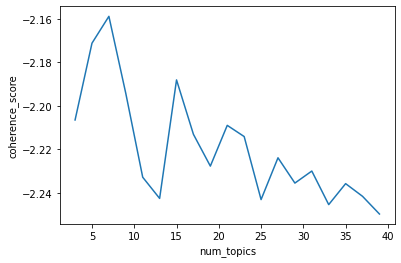

In [42]:
import seaborn as sns
 
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling